## Import libraries

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D)
from keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Digit regconizer

## Data import

In [2]:
train_master = pd.read_csv("../Assignment 1/digit-recognizer/train.csv")
test_master = pd.read_csv("../Assignment 1/digit-recognizer/test.csv")

train = train_master.copy().drop("label", axis=1)
label = train_master.label
test = test_master.copy()

In [3]:
print(train.shape)
print(label.shape)
print(test.shape)

(42000, 784)
(42000,)
(28000, 784)


In [4]:
train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=42)
print(X_train.shape)
print(type(X_train))
print(X_test.shape)
print(type(X_test))

(33600, 784)
<class 'pandas.core.frame.DataFrame'>
(8400, 784)
<class 'pandas.core.frame.DataFrame'>


## Traditional Machine learning

In [6]:
knn = KNeighborsClassifier(n_neighbors=1)
#knn.fit(X, y)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [9]:
y_pred = knn.predict(X_test.to_numpy())
print(y_pred)

[8 1 9 ... 3 0 9]


### Evaluation

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       816
           1       0.97      1.00      0.98       909
           2       0.98      0.95      0.97       846
           3       0.97      0.96      0.96       937
           4       0.98      0.97      0.97       839
           5       0.96      0.96      0.96       702
           6       0.98      0.99      0.98       785
           7       0.96      0.97      0.96       893
           8       0.98      0.94      0.96       835
           9       0.94      0.96      0.95       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



### Test model

The digit is 7


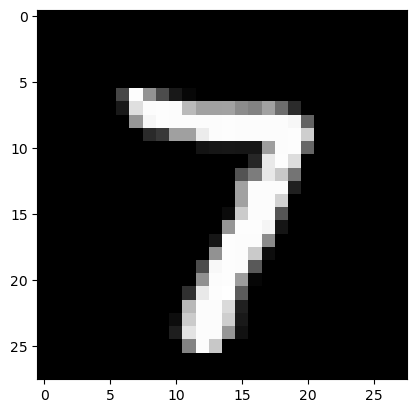

In [42]:
plt.imshow(X_test.iloc[1200].values.reshape(28, 28), cmap="gray")
print(f'The digit is {y_pred[1200]}')

## CNN

### Processing data

In [26]:
X_train_norm = X_train / 255
X_test_norm = X_test / 255

In [36]:
n_classes = 10

Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

### Define Model

In [38]:
model = Sequential()
# hidden layer
model.add(Dense(100, input_shape=(784,), activation='relu'))
# output layer
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train model

In [39]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.fit(X_train_norm, Y_train, batch_size=64, epochs=10, validation_data=(X_test_norm, Y_test))

Epoch 1/10
525/525 [==============================] - 1s 825us/step - loss: 0.3799 - accuracy: 0.8955 - val_loss: 0.2267 - val_accuracy: 0.9338
Epoch 2/10
525/525 [==============================] - 0s 687us/step - loss: 0.1815 - accuracy: 0.9480 - val_loss: 0.1667 - val_accuracy: 0.9512
Epoch 3/10
525/525 [==============================] - 0s 665us/step - loss: 0.1330 - accuracy: 0.9629 - val_loss: 0.1414 - val_accuracy: 0.9592
Epoch 4/10
525/525 [==============================] - 0s 692us/step - loss: 0.1044 - accuracy: 0.9707 - val_loss: 0.1244 - val_accuracy: 0.9642
Epoch 5/10
525/525 [==============================] - 0s 718us/step - loss: 0.0859 - accuracy: 0.9750 - val_loss: 0.1169 - val_accuracy: 0.9650
Epoch 6/10
525/525 [==============================] - 0s 818us/step - loss: 0.0700 - accuracy: 0.9796 - val_loss: 0.1095 - val_accuracy: 0.9661
Epoch 7/10
525/525 [==============================] - 0s 866us/step - loss: 0.0580 - accuracy: 0.9837 - val_loss: 0.1053 - val_accuracy:

> CNN achieves an incredible accuracy of 99.07%

### Test model

263/263 [==============================] - 0s 324us/step
The digit is 8


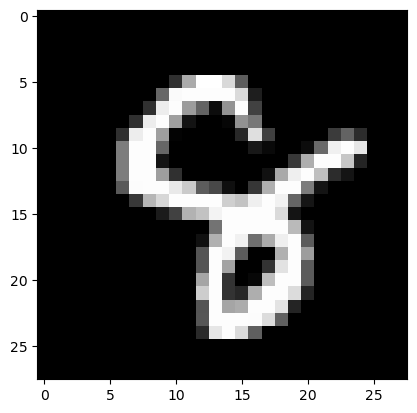

In [46]:
y_pred_cnn = model.predict(X_test)
plt.imshow(X_test.iloc[1900].values.reshape(28, 28), cmap="gray")
print(f'The digit is {np.argmax(y_pred_cnn[1900])}')

# Dog breed

In [40]:
train_path = "../Assignment 1/dog-breed-identification/train/"
labels_path = "../Assignment 1/dog-breed-identification/labels.csv"
img_size = [64, 64, 3]

In [63]:
!echo "The number of images in the train folder is: $(ls dog-breed-identification/train/*.jpg | wc -l)"
!echo "The number of images in the test folder is: $(ls dog-breed-identification/test/*.jpg | wc -l)"

The number of images in the train folder is:    10222
The number of images in the test folder is:    10357


## Data import

In [11]:
labels_master = pd.read_csv("../Assignment 1/dog-breed-identification/labels.csv")
labels = labels_master.copy()

In [64]:
len(labels)

10222

In [13]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [15]:
labels["path"] = train_path + labels.id + ".jpg"
labels.drop("id", axis=1, inplace=True)
labels.head()

,breed,path
0,boston_bull,../Assignment 1/dog-breed-identification/train...
1,dingo,../Assignment 1/dog-breed-identification/train...
2,pekinese,../Assignment 1/dog-breed-identification/train...
3,bluetick,../Assignment 1/dog-breed-identification/train...
4,golden_retriever,../Assignment 1/dog-breed-identification/train...


In [16]:
breeds = sorted(labels["breed"].unique().tolist())
#len(breeds)
class_to_num = dict(zip(breeds, range(len(breeds))))

In [30]:
def image_processing(data: pd.DataFrame, image_size: tuple):
    X = np.zeros(
        [len(data), image_size[0], image_size[1], image_size[2]],
        dtype=np.uint8,
    )
    y = np.zeros([len(data), 1], dtype=np.uint8)
    for idx, row in tqdm(data.iterrows()):
        img_pixels = load_img(row["path"], target_size=image_size)
        X[idx] = img_pixels
        y[idx] = class_to_num[row["breed"]]
    return X, y

In [31]:
X, y = image_processing(labels, img_size)

10222it [00:16, 629.71it/s]


In [22]:
X[0]

array([[[153,  91,  40],
        [182, 127,  73],
        [172, 123,  67],
        ...,
        [204, 182,  60],
        [188, 156,  83],
        [189, 157,  84]],

       [[189, 136,  94],
        [142,  95,  51],
        [148, 108,  59],
        ...,
        [238, 211, 104],
        [224, 192, 105],
        [194, 162,  75]],

       [[111,  70,  38],
        [ 99,  61,  25],
        [194, 160, 123],
        ...,
        [229, 194, 110],
        [227, 192,  88],
        [212, 177,  73]],

       ...,

       [[186, 119,  66],
        [183, 116,  63],
        [189, 123,  71],
        ...,
        [186, 134,  86],
        [229, 175, 128],
        [221, 167, 120]],

       [[186, 119,  66],
        [184, 117,  64],
        [190, 124,  72],
        ...,
        [163, 101,  62],
        [214, 161, 109],
        [212, 159, 107]],

       [[181, 114,  61],
        [186, 119,  66],
        [191, 125,  73],
        ...,
        [132,  63,  30],
        [180, 128,  70],
        [190, 138,  80]]

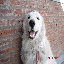

In [59]:
img = load_img("../Assignment 1/dog-breed-identification/train/0a0c223352985ec154fd604d7ddceabd.jpg", target_size=img_size)
img

In [64]:
array_test = img_to_array(img, dtype=np.uint8)

In [76]:
array_img = img_to_array(img, dtype=np.uint8)
array_img_t = array_img.flatten()
array_img_t = array_img_t.reshape(1,-1)
array_img_t
#array_img.flatten().shape

array([[110,  70,  70, ..., 142, 136, 140]], dtype=uint8)

In [79]:
array_img_t.shape

(1, 12288)

In [80]:
column_names = [f'pixel{num}' for num in range(array_img_t.shape[1])]
df_image = pd.DataFrame(array_img_t, columns=column_names)

df_image.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel12278,pixel12279,pixel12280,pixel12281,pixel12282,pixel12283,pixel12284,pixel12285,pixel12286,pixel12287
0,110,70,70,115,75,75,121,81,81,131,...,190,109,106,115,144,142,147,142,136,140


In [88]:
# Extract the filename without extension
image_path = '../Assignment 1/dog-breed-identification/train/0a0c223352985ec154fd604d7ddceabd.jpg'

# Find the corresponding label
label = labels.loc[labels['path'] == image_path, 'breed'].values[0]

# Add the label to the DataFrame
df_image['label'] = label

# Now df_image has the image data and the corresponding label
df_image.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel12279,pixel12280,pixel12281,pixel12282,pixel12283,pixel12284,pixel12285,pixel12286,pixel12287,label
0,110,70,70,115,75,75,121,81,81,131,...,109,106,115,144,142,147,142,136,140,kuvasz


## Splitting data

## Traditional machine learning

## CNN